# YOLOv1 — строим, обучаем и оцениваем детектор объектов

На этом занятии мы:
1. Разберём архитектуру YOLOv1
2. Напишем функцию потерь
3. Обучим модель на небольшом датасете
4. Оценим качество через mAP

## 1. Импорты

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import VOCDetection
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm

torch.manual_seed(123)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Используем: {DEVICE}')

Используем: cuda


## 2. Датасет

Используем датасет с тремя классами фруктов: [ссылка на Kaggle](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection)

Каждый пример: изображение + список боксов в формате **midpoint** `[x_c, y_c, w, h]`,  
где все координаты нормализованы от 0 до 1 относительно размера изображения.

In [2]:
CLASS_NAMES   = ['apple', 'banana', 'orange']
CLASS_TO_IDX  = {c: i for i, c in enumerate(CLASS_NAMES)}

S = 7
B = 2
C = len(CLASS_NAMES) # 3 класса: apple, banana, orange

# Гиперпараметры
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 0
EPOCHS = 15
BATCH_SIZE = 16       

In [3]:
# Обработки и аугментации: меняем размер на 224x224
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    # Нормализация ImageNet (обязательна для ResNet)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Функция ниже собирает датасет. Для этого она парсит XML-файл. Можно сильно не вникать, главное — что мы получим пары "изображение — лейбл (класс, координаты бокса)"

In [4]:
import os
import xml.etree.ElementTree as ET
from PIL import Image


class YOLODataset(torch.utils.data.Dataset):
    """
    Читает датасет фруктов с Kaggle (mbkinaci/fruit-images-for-object-detection).

    Ожидаемая структура — .jpg и .xml лежат в одной папке:
        /kaggle/input/fruit-images-for-object-detection/train_zip/train/
        /kaggle/input/fruit-images-for-object-detection/test_zip/test/

    Локально можно распаковать куда угодно и передать тот же путь.
    """

    def __init__(self, folder, transform=None):
        self.folder    = folder
        self.transform = transform
        # Собираем список всех изображений в папке
        self.ids = [
            f[:-4] for f in os.listdir(folder) if f.endswith('.jpg')
        ]

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        
        # Загружаем и трансформируем изображение
        img_path = os.path.join(self.folder, f'{name}.jpg')
        image = Image.open(img_path).convert("RGBA").convert("RGB")
        # print(image.size)
        img_w, img_h = image.size
        
        if self.transform:
            image = self.transform(image)
            
        # Загружаем XML
        xml_path = os.path.join(self.folder, f'{name}.xml')
        root = ET.parse(xml_path).getroot()
        
        # Матрица таргетов: S x S x (C + B*5)
        # S=7, B=2, C=3 (apple, banana, orange) -> глубина 13
        # Структура вектора по глубине:
        # [0:3] - one-hot классы
        # [3]   - confidence (есть объект или нет)
        # [4:8] - координаты (x_cell, y_cell, w_img, h_img)
        # Остальное (второй бокс) - нули
        label_matrix = torch.zeros(S, S, C + 5 * B)
        
        for obj in root.findall('object'):
            name_cls = obj.find('name').text
            if name_cls not in CLASS_TO_IDX:
                continue
            class_id = CLASS_TO_IDX[name_cls]
            
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            xmax = int(bbox.find('xmax').text)
            ymin = int(bbox.find('ymin').text)
            ymax = int(bbox.find('ymax').text)
            
            # Считаем координаты относительно ВСЕГО изображения (0..1)
            x_center = ((xmin + xmax) / 2) / img_w
            y_center = ((ymin + ymax) / 2) / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h
            
            # Определяем ячейку сетки
            row = int(y_center * S)
            col = int(x_center * S)
            
            # Защита от выхода за границы (на всякий случай)
            if row >= S: row = S - 1
            if col >= S: col = S - 1
            
            # Координаты внутри ячейки (0..1)
            x_cell = x_center * S - col
            y_cell = y_center * S - row
            
            w_cell = width 
            h_cell = height
            
            # Заполняем только если в ячейке еще нет объекта
            # Индекс C (3) - это confidence
            if label_matrix[row, col, C] == 0:
                # 1. Ставим класс (one-hot)
                label_matrix[row, col, class_id] = 1
                
                # 2. Ставим Confidence = 1
                label_matrix[row, col, C] = 1
                
                # 3. Ставим координаты бокса
                # x, y, w, h пишутся в позиции C+1 .. C+5
                box_coordinates = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                label_matrix[row, col, C+1 : C+5] = box_coordinates
                
                # ВТОРОЙ БОКС НЕ ЗАПОЛНЯЕМ! Оставляем нулями.
                
        return image, label_matrix

In [5]:
# На Kaggle: добавь датасет mbkinaci/fruit-images-for-object-detection через кнопку +Data
TRAIN_DIR = '/kaggle/input/datasets/mbkinaci/fruit-images-for-object-detection/train_zip/train'
VAL_DIR   = '/kaggle/input/datasets/mbkinaci/fruit-images-for-object-detection/test_zip/test'

# Локально: распакуй архив и укажи путь к папке с .jpg и .xml
# TRAIN_DIR = './fruit/train'
# VAL_DIR   = './fruit/test'

train_dataset = YOLODataset(folder=TRAIN_DIR, transform=train_transform)
val_dataset   = YOLODataset(folder=VAL_DIR,   transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Train: {len(train_dataset)} изображений')
print(f'Val:   {len(val_dataset)} изображений')

Train: 240 изображений
Val:   60 изображений


In [6]:
train_dataset[0][0].shape

torch.Size([3, 224, 224])

## 3. Проверяем датасет визуально

Всегда полезно посмотреть на данные перед обучением — убедиться что боксы на месте.

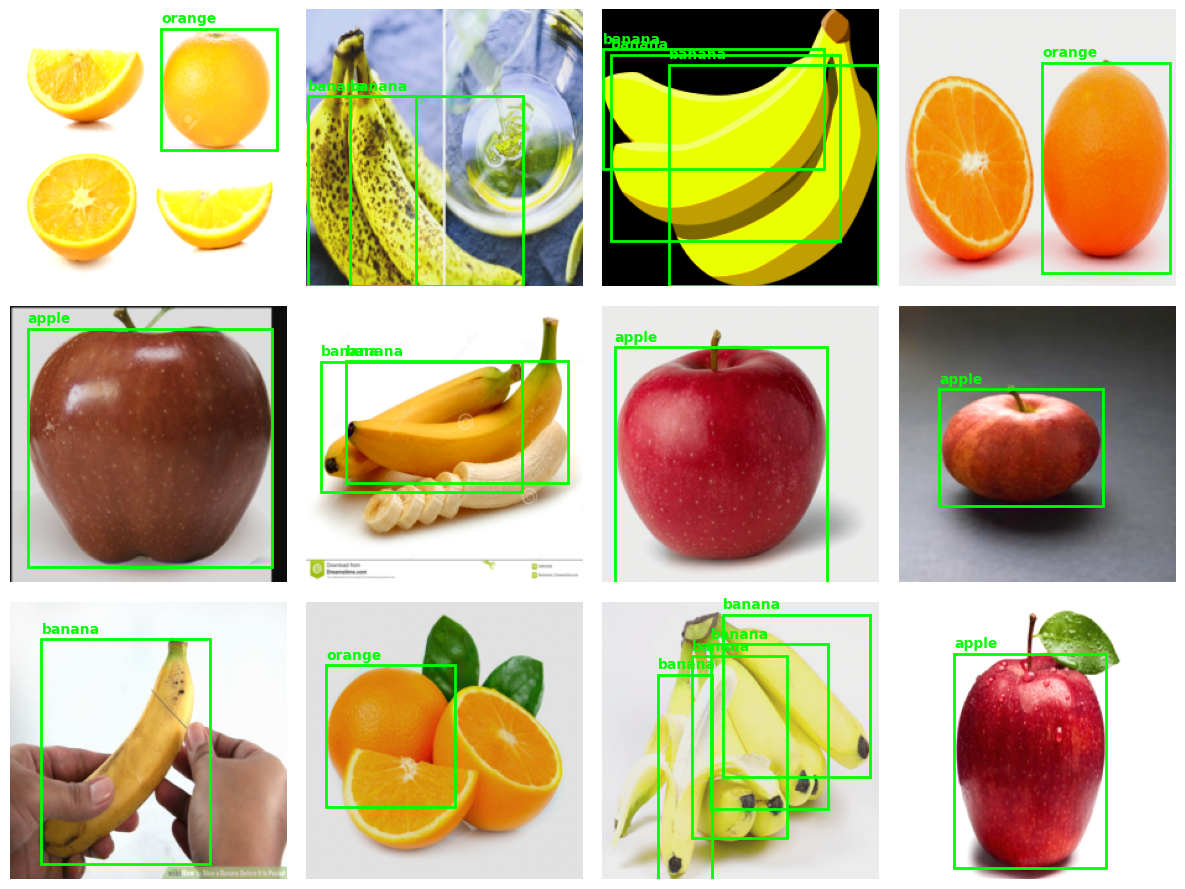

In [7]:
def show_dataset_grid(dataset, n_rows=3, n_cols=4):
    # Инверсия нормализации для отрисовки
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    # Берем случайные индексы
    indices = torch.randperm(len(dataset))[:n_rows * n_cols]

    for ax, idx in zip(axes.flatten(), indices):
        image, label = dataset[idx.item()]
        
        # Денормализация картинки
        img_np = inv_norm(image).permute(1, 2, 0).clamp(0, 1).numpy()
        ax.imshow(img_np)
        ax.axis('off')

        # Проходим по сетке 7x7
        for row in range(S):
            for col in range(S):
                # Проверяем Confidence (индекс C)
                # У нас там 1, если есть объект
                if label[row, col, C] == 1:
                    # Координаты (C+1 .. C+5)
                    # x, y - это смещение внутри ячейки
                    # w, h - это ширина относительно ВСЕЙ картинки (0..1)
                    
                    x_cell = label[row, col, C+1].item()
                    y_cell = label[row, col, C+2].item()
                    w      = label[row, col, C+3].item()
                    h      = label[row, col, C+4].item()
                    
                    # Восстанавливаем глобальные координаты центра
                    x_c = (col + x_cell) / S
                    y_c = (row + y_cell) / S
                    
                    # Находим класс (argmax по первым C элементам)
                    cid = label[row, col, :C].argmax().item()
                    
                    # Рисуем (умножаем на размер картинки 224)
                    IMG_SIZE = 224
                    x0 = (x_c - w/2) * IMG_SIZE
                    y0 = (y_c - h/2) * IMG_SIZE
                    
                    rect = patches.Rectangle(
                        (x0, y0), w*IMG_SIZE, h*IMG_SIZE,
                        linewidth=2, edgecolor='lime', facecolor='none'
                    )
                    ax.add_patch(rect)
                    ax.text(x0, y0-5, CLASS_NAMES[cid], color='lime', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.show()

show_dataset_grid(train_dataset)

## 4. Архитектура YOLOv1

YOLOv1 состоит из двух частей:
- **Свёточный Backbone** (GoogleNet-like) — 24 свёрточных слоя, извлекают признаки из изображения  
- **FC-голова** — 2 полносвязных слоя, предсказывают боксы и классы

![архитектура](https://neerc.ifmo.ru/wiki/images/d/d5/YOLONet.png)

Обучать backbone с нуля за короткое время невозможно, веса обученного достать проблематично — лучше мы загрузим новый backbone с помощью уже изученного Transfer Learning :)

Возьмём [ResNet](https://docs.pytorch.org/vision/main/models/resnet.html). На иллюстрации — резнет-50, мы возьмём версию на 18 слоёв. [Ссылка на оригинальную статью](https://arxiv.org/pdf/1512.03385).
![резнет!!](https://habrastorage.org/r/w780/getpro/habr/upload_files/445/1f1/150/4451f11509ee37d5155e5d429a8e4a0a.png)

In [8]:
class YoloFCHead(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C

        self.fc = nn.Sequential(
            nn.Flatten(),                     # [B, 512*7*7]
            nn.Linear(512 * S * S, 2048),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),
            nn.Linear(2048, S * S * (C + 5 * B))
        )

    def forward(self, x):
        # x: [B, 512, 7, 7]
        x = self.fc(x)                        # [B, S*S*(C+5B)]
        x = x.view(
            x.size(0),
            self.S,
            self.S,
            self.C + 5 * self.B
        )                                     # [B, 7, 7, C+5B]
        return x         # БЕЗ активаций

In [9]:
from torchvision.models import resnet18, ResNet18_Weights

class YoloResNet(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        super().__init__()
        self.S = S
        self.B = B
        self.C = C
        
        # 1. Загружаем предобученный ResNet18
        # weights='DEFAULT' загружает веса ImageNet
        self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
        
        # 2. ЗАМОРАЖИВАЕМ ВЕСА (Transfer Learning)
        # Мы не хотим ломать то, что сеть уже выучила
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # 3. Убираем "голову" классификации (fc) и пулинг (avgpool)
        # ResNet18 уменьшает размер в 32 раза. 
        # При входе 224x224 -> на выходе будет 7x7 с 512 каналами.
        # Это идеально совпадает с нашим S=7.
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # 4. Новая голова детекции
        # Вход: 512 каналов. Выход: (C + B*5) каналов.
        
        self.detector = YoloFCHead(S, B, C)

        # Fully convolutional head
        # (Крутая Фишка, можно попробовать раскомментиовать)
        # self.detector = nn.Sequential(
        #     nn.Conv2d(512, 1024, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(1024),
        #     nn.LeakyReLU(0.1),
            
        #     nn.Conv2d(1024, C + B * 5, kernel_size=1),
        # )

    def forward(self, x):
        # x: [batch, 3, 224, 224]
        x = self.features(x)          # -> [batch, 512, 7, 7]
        x = self.detector(x)          # -> [batch, 13, 7, 7] (для C=3, B=2)

        # РАСКОММЕНТИРОВАТЬ, ЕСЛИ ГОЛОВА НА СВЁРТКАХ
        # x = x.permute(0, 2, 3, 1)
        return x

Рассмотрим подробнее отрезанную голову резнета:

In [10]:
a = resnet18(weights=ResNet18_Weights.DEFAULT)
list(a.children())[-2:]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=512, out_features=1000, bias=True)]

## 5. Вспомогательные функции: IoU и NMS

**IoU** (Intersection over Union) — насколько два бокса перекрываются. Используется внутри Loss и при постобработке.

**NMS** (Non-Max Suppression) — убирает дублирующие боксы, оставляя самый уверенный из перекрывающихся.

In [11]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    IoU для боксов в формате midpoint: [x_c, y_c, w, h].

    Аргументы:
        boxes_preds  — тензор (..., 4)
        boxes_labels — тензор (..., 4)
    Возвращает:
        тензор (..., 1) со значениями IoU от 0 до 1
    """
    # Переводим midpoint → corners
    p_x1 = boxes_preds[...,  0:1] - boxes_preds[...,  2:3] / 2
    p_y1 = boxes_preds[...,  1:2] - boxes_preds[...,  3:4] / 2
    p_x2 = boxes_preds[...,  0:1] + boxes_preds[...,  2:3] / 2
    p_y2 = boxes_preds[...,  1:2] + boxes_preds[...,  3:4] / 2

    g_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    g_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    g_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    g_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    inter = (torch.min(p_x2, g_x2) - torch.max(p_x1, g_x1)).clamp(0) * \
            (torch.min(p_y2, g_y2) - torch.max(p_y1, g_y1)).clamp(0)

    area_p = (p_x2 - p_x1).abs() * (p_y2 - p_y1).abs()
    area_g = (g_x2 - g_x1).abs() * (g_y2 - g_y1).abs()

    return inter / (area_p + area_g - inter + 1e-6)

In [12]:
def non_max_suppression(bboxes, iou_threshold=0.5, conf_threshold=0.4):
    """
    NMS: убирает дублирующие боксы.

    Алгоритм:
    1. Отбрасываем боксы с confidence < conf_threshold
    2. Сортируем по confidence (убывание)
    3. Жадно берём лучший бокс и удаляем все с IoU > iou_threshold того же класса

    Формат бокса: [class_id, confidence, x_c, y_c, w, h]
    """
    bboxes = [b for b in bboxes if b[1] > conf_threshold]
    bboxes = sorted(bboxes, key=lambda b: b[1], reverse=True)
    result = []

    while bboxes:
        best = bboxes.pop(0)
        bboxes = [
            b for b in bboxes
            if b[0] != best[0]
            or intersection_over_union(
                torch.tensor(best[2:]), torch.tensor(b[2:])
            ) < iou_threshold
        ]
        result.append(best)

    return result

## 6. Функция потерь YOLOv1

Loss состоит из **4 слагаемых** (уравнение 3 из статьи):

1. **box_loss** — ошибка координат `(x, y, √w, √h)` ответственного бокса  
2. **object_loss** — ошибка confidence там, где объект есть  
3. **noobj_loss** — ошибка confidence там, где объекта нет (вес `λ=0.5`)  
4. **class_loss** — ошибка классификации

`λ_coord=5` усиливает штраф за координаты — их ошибка важнее, чем у пустых ячеек.

Форма и тагета, и предикшенов:
[batch, S, S, C + B*5]

**Почему в конце C + B * 5?** Финальное измерение включает в себя три класса (C) и 5 чисел для каждого из двух боксов: уверенность (confidence, конф) и четыре координаты (центр, ширина-высота)

[класс_1, класс_2, класс_3, конф1, x1, y1, w1, h1, конф2, x2, y2, w2, h2]

Мы упростили датасет и убрали второй бокс для простоты, но в оригинале он есть!

In [13]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = 5
        self.lambda_noobj = 0.5

    def forward(self, predictions, target):
        # predictions: [batch, S, S, C + B*5] (все значения 0..1)
        # target:      [batch, S, S, C + B*5]
        
        # Маска: где есть объект (1), где нет (0). Берем из Confidence первого бокса в таргете
        # target структуру ожидаем такую: [C классов, conf, x, y, w, h, ...]
        # У нас в датасете ставится conf=1 по индексу C.
        exists_box = target[..., self.C].unsqueeze(3) # [batch, S, S, 1]

        # --- 1. Координаты (Box Loss) ---
        # Считаем только для ячеек, где ЕСТЬ объект
        # Упрощение для урока: Считаем, что первый бокс модели отвечает за первый бокс таргета.
        
        # Берем параметры бокса (x, y, w, h)
        # Индексы: C+1:C+5
        box_preds = predictions[..., self.C+1:self.C+5]
        box_targets = target[..., self.C+1:self.C+5]
        
        # В статье YOLOv1 лосс считается чуть сложнее, но мы возьмём просто MSE
        
        box_loss = self.mse(
            torch.flatten(exists_box * box_preds, end_dim=-2),
            torch.flatten(exists_box * box_targets, end_dim=-2)
        )

        # --- 2. Object Loss (Confidence) ---
        # Предсказал объект там, где он есть
        pred_conf = predictions[..., self.C]
        target_conf = target[..., self.C]
        
        obj_loss = self.mse(
            torch.flatten(exists_box.squeeze(3) * pred_conf),
            torch.flatten(exists_box.squeeze(3) * target_conf)
        )

        # --- 3. No Object Loss ---
        # Штрафуем уверенность там, где объекта НЕТ
        # ПЛЮС штрафуем второй бокс (индекс C+5), если он лишний (в нашей упрощенной схеме он всегда лишний)
        
        noobj_loss = self.mse(
            torch.flatten((1 - exists_box.squeeze(3)) * pred_conf),
            torch.flatten((1 - exists_box.squeeze(3)) * target_conf)
        )
        
        # Дополнительно гасим второй бокс (индекс C+5), так как в таргете у нас всегда 1 объект на ячейку
        pred_conf_2 = predictions[..., self.C + 5]
        target_conf_2 = target[..., self.C + 5] # Там нули
        
        noobj_loss += self.mse(
            torch.flatten(pred_conf_2), 
            torch.flatten(target_conf_2)
        )

        # --- 4. Class Loss ---
        # Ошибка классификации (только если есть объект)
        class_preds = predictions[..., :self.C]
        class_targets = target[..., :self.C]
        
        class_loss = self.mse(
            torch.flatten(exists_box * class_preds, end_dim=-2),
            torch.flatten(exists_box * class_targets, end_dim=-2)
        )

        loss = (
            self.lambda_coord * box_loss
            + obj_loss
            + self.lambda_noobj * noobj_loss
            + class_loss
        )
        return loss

## 7. Обучение

Стандартный PyTorch-цикл: `forward → loss → backward → step`.  
`ReduceLROnPlateau` автоматически снижает lr, если метрика не улучшается.

In [14]:
def train_one_epoch(train_loader, model, optimizer, criterion):
    """Один эпох обучения. Возвращает средний loss."""
    model.train()
    train_losses = []

    for images, labels in tqdm(train_loader, desc='Train', leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        train_loss = criterion(model(images), labels)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        train_losses.append(train_loss.item())

    return sum(train_losses) / len(train_losses)

In [15]:
model = YoloResNet(S=S, B=B, C=C).to(DEVICE)
print("Модель создана. Backbone заморожен.")
# Проверка размерности
dummy = torch.randn(2, 3, 224, 224).to(DEVICE)
out = model(dummy)
print(f"Выход: {out.shape}") 
# Должно быть: [2, 7, 7, 13] (где 13 = 3 класса + 2 * 5)

Модель создана. Backbone заморожен.
Выход: torch.Size([2, 7, 7, 13])


## 8. Валидация — mAP

**mAP** (mean Average Precision) — стандартная метрика для object detection.  
Используем `torchmetrics.detection.MeanAveragePrecision` — не пишем вручную.

In [16]:
def decode_predictions(pred_tensor, conf_threshold=0.5, iou_threshold=0.5):
    """
    pred_tensor: (batch, S, S, C + B*5) -- выход модели после Sigmoid
    """
    batch_size = pred_tensor.shape[0]
    pred_tensor = pred_tensor.cpu()
    all_boxes = []

    for img_idx in range(batch_size):
        boxes = []
        for row in range(S):
            for col in range(S):
                # Получаем вектор для ячейки
                cell = pred_tensor[img_idx, row, col]
                
                # Разбираем 1-й бокс (индексы C .. C+5)
                # cell[C] - confidence
                conf = cell[C].item()
                
                if conf > conf_threshold:
                    # Класс
                    cid = cell[:C].argmax().item()
                    
                    x_cell = cell[C+1].item()
                    y_cell = cell[C+2].item()
                    w      = cell[C+3].item()
                    h      = cell[C+4].item()
                    
                    x_c = (col + x_cell) / S
                    y_c = (row + y_cell) / S
                    
                    boxes.append([cid, conf, x_c, y_c, w, h])
        
        # NMS
        if boxes:
            all_boxes.append(non_max_suppression(boxes, iou_threshold, conf_threshold))
        else:
            all_boxes.append([])
            
    return all_boxes

In [17]:
from torchmetrics.detection import MeanAveragePrecision

def evaluate_map(model, loader, conf_threshold=0.1, iou_threshold=0.5, display=False):
    """
    Считаем mAP.
    Важно: переводим все координаты в абсолютные пиксели (0..224)
    и формат XYXY (xmin, ymin, xmax, ymax).
    """
    model.eval()
    
    # Используем формат xyxy - он самый надежный для метрик
    metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
    
    IMG_SIZE = 224
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Eval', leave=False):
            images = images.to(DEVICE)
            
            # --- 1. ПРЕДСКАЗАНИЯ ---
            # Получаем сырой выход [batch, S, S, 30]
            preds_raw = model(images)
            
            # Декодируем в список боксов [class, conf, xc, yc, w, h] (0..1)
            # Используем ту функцию decode_predictions, которую исправили ранее
            batch_pred_boxes = decode_predictions(preds_raw, conf_threshold, iou_threshold)
            
            pred_list = []
            for i, boxes in enumerate(batch_pred_boxes):
                # boxes - список списков для одной картинки
                sample_preds = dict(boxes=torch.tensor([]), scores=torch.tensor([]), labels=torch.tensor([]))
                
                if len(boxes) > 0:
                    # Превращаем в тензор
                    boxes_t = torch.tensor(boxes) # [N, 6]
                    
                    # Разбираем
                    p_classes = boxes_t[:, 0].long() # классы
                    p_scores  = boxes_t[:, 1] # уверенность
                    p_cx      = boxes_t[:, 2] # координаты (и 3 ниже)
                    p_cy      = boxes_t[:, 3]
                    p_w       = boxes_t[:, 4]
                    p_h       = boxes_t[:, 5]
                    
                    # Конвертация cxcywh (0..1) -> xyxy (0..224)
                    x1 = (p_cx - p_w/2) * IMG_SIZE
                    y1 = (p_cy - p_h/2) * IMG_SIZE
                    x2 = (p_cx + p_w/2) * IMG_SIZE
                    y2 = (p_cy + p_h/2) * IMG_SIZE
                    
                    # Собираем [N, 4]
                    p_bboxes = torch.stack([x1, y1, x2, y2], dim=1)
                    
                    sample_preds['boxes'] = p_bboxes
                    sample_preds['scores'] = p_scores
                    sample_preds['labels'] = p_classes
                
                pred_list.append(sample_preds)

            # --- 2. GROUND TRUTH (ТАРГЕТЫ) ---
            target_list = []
            labels = labels.cpu() # Работаем на CPU
            
            for i in range(labels.shape[0]): # По батчу
                label_matrix = labels[i]
                gt_boxes = []
                gt_classes = []
                
                # Проходим по сетке 7x7
                for row in range(S):
                    for col in range(S):
                        # Если есть объект
                        if label_matrix[row, col, C] == 1:
                            # Достаем параметры (они там 0..1, w/h не делены на S)
                            x_cell = label_matrix[row, col, C+1]
                            y_cell = label_matrix[row, col, C+2]
                            w      = label_matrix[row, col, C+3]
                            h      = label_matrix[row, col, C+4]
                            
                            # Восстанавливаем глобальные cx, cy (0..1)
                            cx = (col + x_cell) / S
                            cy = (row + y_cell) / S
                            
                            # Класс
                            cls_id = torch.argmax(label_matrix[row, col, :C])
                            
                            # Конвертация в xyxy (0..224)
                            x1 = (cx - w/2) * IMG_SIZE
                            y1 = (cy - h/2) * IMG_SIZE
                            x2 = (cx + w/2) * IMG_SIZE
                            y2 = (cy + h/2) * IMG_SIZE
                            
                            gt_boxes.append([x1, y1, x2, y2])
                            gt_classes.append(cls_id)
                
                sample_targets = dict(boxes=torch.tensor([]), labels=torch.tensor([]))
                if len(gt_boxes) > 0:
                    sample_targets['boxes'] = torch.tensor(gt_boxes)
                    sample_targets['labels'] = torch.tensor(gt_classes, dtype=torch.long)
                    
                target_list.append(sample_targets)
            
            # Обновляем метрику для текущего батча
            metric.update(pred_list, target_list)

    # Считаем итоговый mAP
    res = metric.compute()
    if display:
        print(f'mAP@0.50: {res["map_50"]:.4f}')
        print(f'mAP@0.50:0.95: {res["map"]:.4f}')
    return res

In [18]:
val_results = evaluate_map(model, val_loader, display=True)

mAP@0.50: 0.0001
mAP@0.50:0.95: 0.0000


In [19]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn   = YoloLoss(S=S, B=B, C=C)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=7, mode='min')

EPOCHS = 15
train_losses = []
val_maps = []
for epoch in range(EPOCHS):
    train_loss = train_one_epoch(train_loader, model, optimizer, loss_fn)
    train_losses.append(train_loss)
    val_map = evaluate_map(model, val_loader)
    val_maps.append(val_map["map_50"])
    # scheduler.step(avg_loss)
    print(f'Epoch {epoch+1:>2}/{EPOCHS} | loss_train: {train_loss:.4f} | val_mAp: {val_map["map_50"]:.4f}')

torch.save(model.state_dict(), 'yolov1.pth')
print('Модель сохранена в yolov1.pth')

Epoch  1/15 | loss_train: 1242.7161 | val_mAp: 0.0301


Epoch  2/15 | loss_train: 244.0433 | val_mAp: 0.0212


Epoch  3/15 | loss_train: 181.1355 | val_mAp: 0.1249


Epoch  4/15 | loss_train: 152.5180 | val_mAp: 0.1873


Epoch  5/15 | loss_train: 126.5774 | val_mAp: 0.2423


Epoch  6/15 | loss_train: 111.1062 | val_mAp: 0.1675


Epoch  7/15 | loss_train: 103.3586 | val_mAp: 0.2736


Epoch  8/15 | loss_train: 90.7478 | val_mAp: 0.1864


Epoch  9/15 | loss_train: 79.5794 | val_mAp: 0.3045


Epoch 10/15 | loss_train: 72.6800 | val_mAp: 0.2681


Epoch 11/15 | loss_train: 69.8419 | val_mAp: 0.2898


Epoch 12/15 | loss_train: 62.5319 | val_mAp: 0.2546


Epoch 13/15 | loss_train: 61.8600 | val_mAp: 0.2522


Epoch 14/15 | loss_train: 56.2142 | val_mAp: 0.3076


Epoch 15/15 | loss_train: 58.3478 | val_mAp: 0.2336
Модель сохранена в yolov1.pth


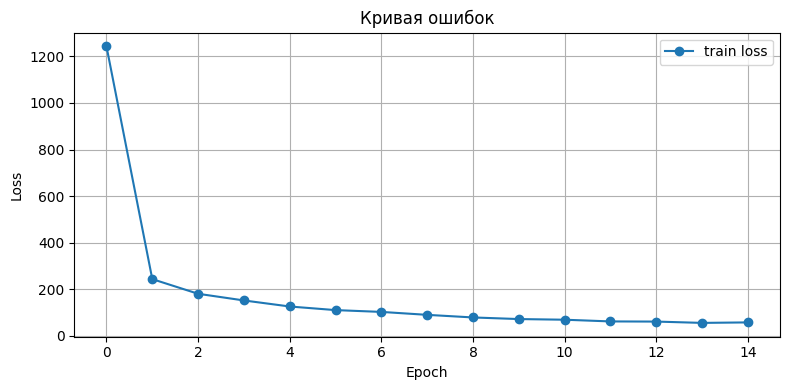

In [20]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, marker='o', linewidth=1.5, label='train loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Кривая ошибок')
plt.grid(True); plt.tight_layout(); plt.legend(); plt.show()

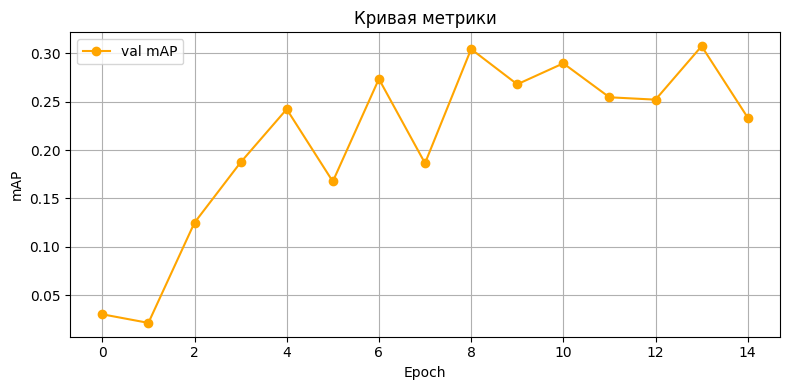

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(val_maps, color='orange', marker='o', linewidth=1.5, label='val mAP')
plt.xlabel('Epoch'); plt.ylabel('mAP')
plt.title('Кривая метрики')
plt.grid(True); plt.tight_layout(); plt.legend(); plt.show()

In [22]:
val_results = evaluate_map(model, val_loader, display=True)

mAP@0.50: 0.2336
mAP@0.50:0.95: 0.0785


## 9. Смотрим на предсказания

Зелёный = ground truth, красный = предсказание после NMS.

In [23]:
def show_predictions(model, dataset, n_images=4, conf_threshold=0.5):
    model.eval()
    
    # 1. Берем случайные картинки
    indices = torch.randperm(len(dataset))[:n_images]
    
    # Готовим графики
    fig, axes = plt.subplots(n_images, 2, figsize=(10, n_images * 4))
    if n_images == 1: axes = axes.reshape(1, -1) # Фикс для одной картинки
    
    # Инверсия нормализации для отображения (ImageNet stats)
    inv_norm = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    
    IMG_SIZE = 224  # Размер картинки для ResNet
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx.item()]
        
        # Подготовка картинки для отрисовки
        img_vis = inv_norm(image).permute(1, 2, 0).clamp(0, 1).numpy()
        
        # --- ЛЕВАЯ КОЛОНКА: Ground Truth (Зеленый) ---
        ax_gt = axes[i, 0]
        ax_gt.imshow(img_vis)
        ax_gt.set_title("Ground Truth")
        ax_gt.axis('off')
        
        for row in range(S):
            for col in range(S):
                # Если в ячейке есть объект (conf=1 по индексу C)
                if label[row, col, C] == 1:
                    # Достаем параметры
                    x_cell = label[row, col, C+1].item()
                    y_cell = label[row, col, C+2].item()
                    w      = label[row, col, C+3].item() # БЕЗ деления на S!
                    h      = label[row, col, C+4].item() # БЕЗ деления на S!
                    
                    # Глобальные координаты центра (0..1)
                    x_c = (col + x_cell) / S
                    y_c = (row + y_cell) / S
                    
                    # Класс
                    cid = label[row, col, :C].argmax().item()
                    
                    # Рисуем
                    x0 = (x_c - w/2) * IMG_SIZE
                    y0 = (y_c - h/2) * IMG_SIZE
                    
                    rect = patches.Rectangle(
                        (x0, y0), w*IMG_SIZE, h*IMG_SIZE,
                        linewidth=2, edgecolor='lime', facecolor='none'
                    )
                    ax_gt.add_patch(rect)
                    ax_gt.text(x0, y0-5, CLASS_NAMES[cid], color='lime', weight='bold')

        # --- ПРАВАЯ КОЛОНКА: Предсказания (Красный) ---
        ax_pred = axes[i, 1]
        ax_pred.imshow(img_vis)
        ax_pred.set_title("Prediction")
        ax_pred.axis('off')
        
        # Прогоняем модель
        with torch.no_grad():
            # Добавляем батч-размерность
            pred_tensor = model(image.unsqueeze(0).to(DEVICE)) # Выход: [1, S, S, 30]
            
            # Декодируем (функцию decode_predictions мы уже исправили)
            boxes_list = decode_predictions(pred_tensor, conf_threshold=conf_threshold)
            # decode возвращает список списков (по батчу), берем первый элемент
            pred_boxes = boxes_list[0]
            
        for box in pred_boxes:
            # box: [class_id, conf, x_c, y_c, w, h]
            cid  = int(box[0])
            conf = box[1]
            x_c  = box[2]
            y_c  = box[3]
            w    = box[4]
            h    = box[5]
            
            x0 = (x_c - w/2) * IMG_SIZE
            y0 = (y_c - h/2) * IMG_SIZE
            
            rect = patches.Rectangle(
                (x0, y0), w*IMG_SIZE, h*IMG_SIZE,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax_pred.add_patch(rect)
            ax_pred.text(x0, y0-5, f"{CLASS_NAMES[cid]} {conf:.2f}", color='red', weight='bold')

    plt.tight_layout()
    plt.show()

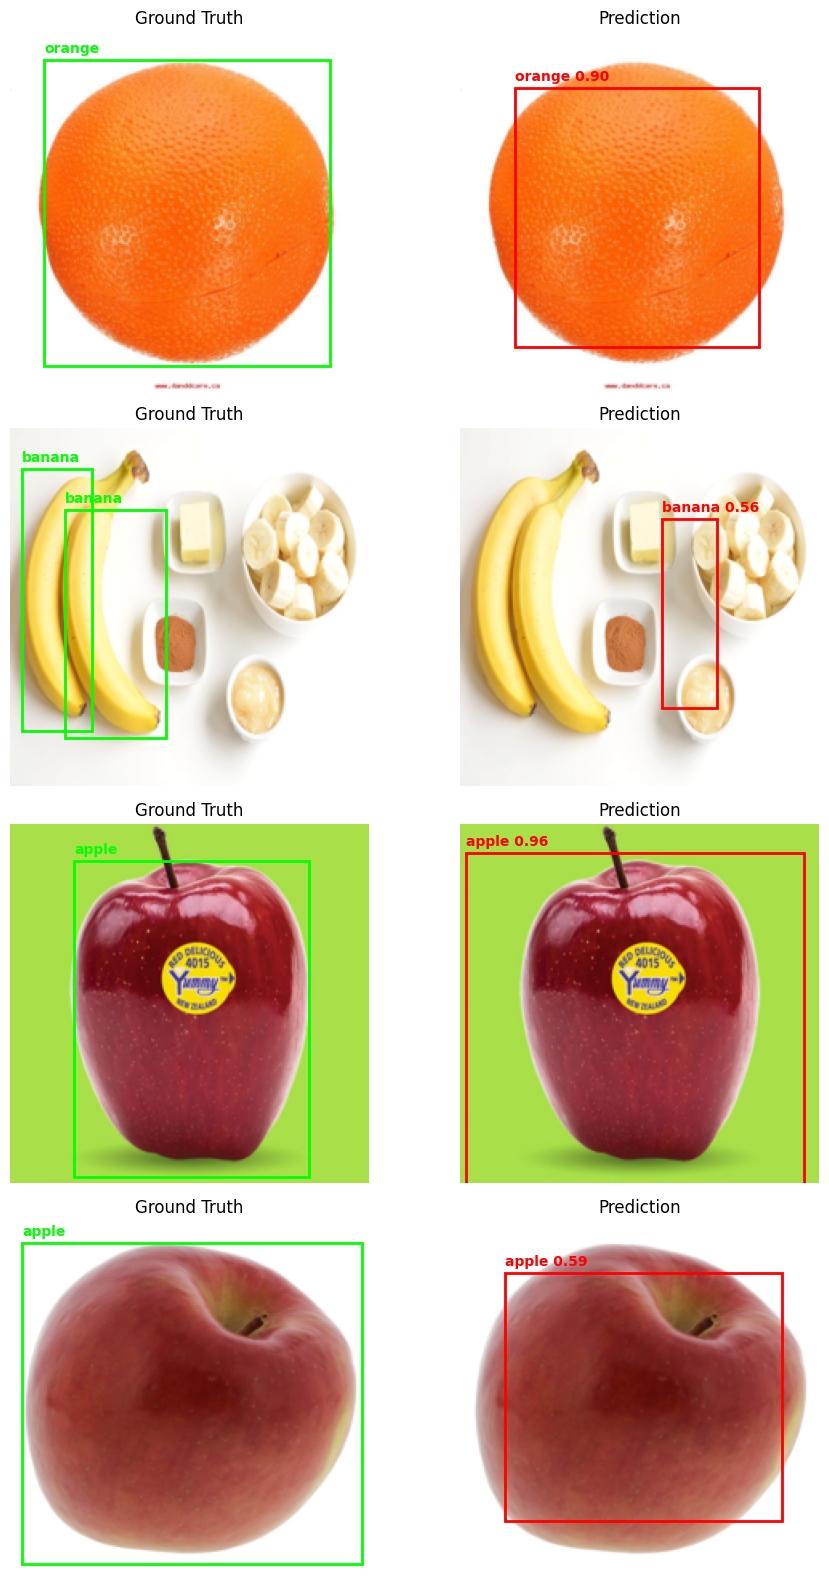

In [24]:
show_predictions(model, val_dataset)